# Модель, определяющая ежедневное оптимальное количество сотрудников магазина

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor

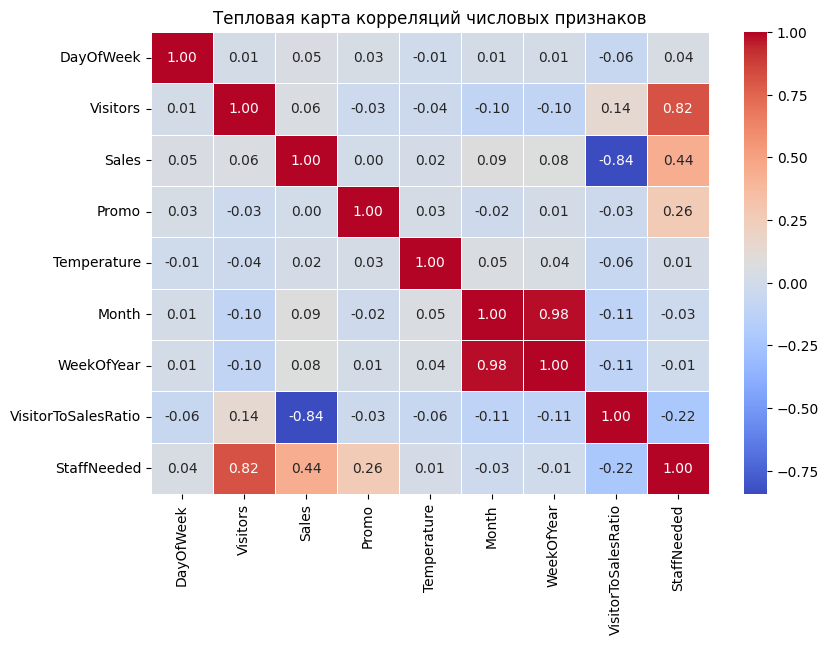

Средний MSE из кросс-валидации: 0.02669936743686476
Gradient Boosting: MSE = 0.03931396693750258 R^2 = 0.9834462602868244


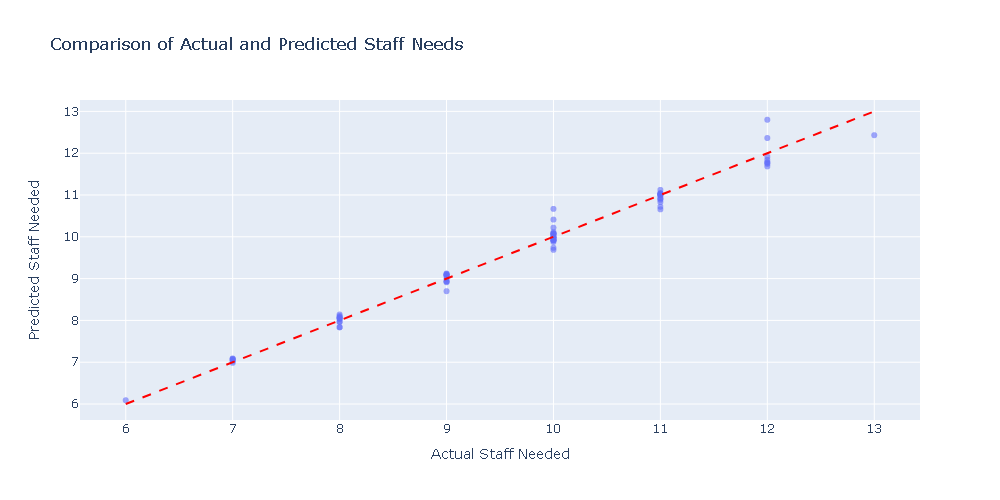

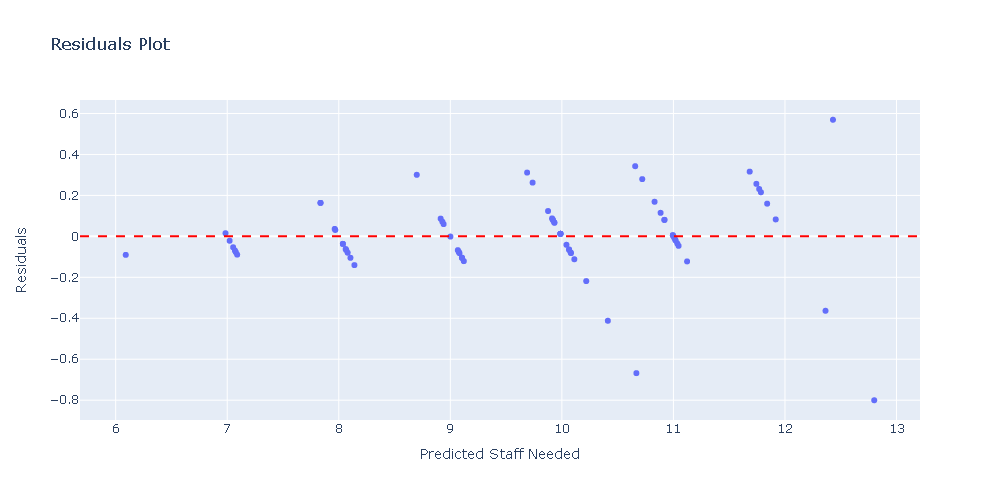

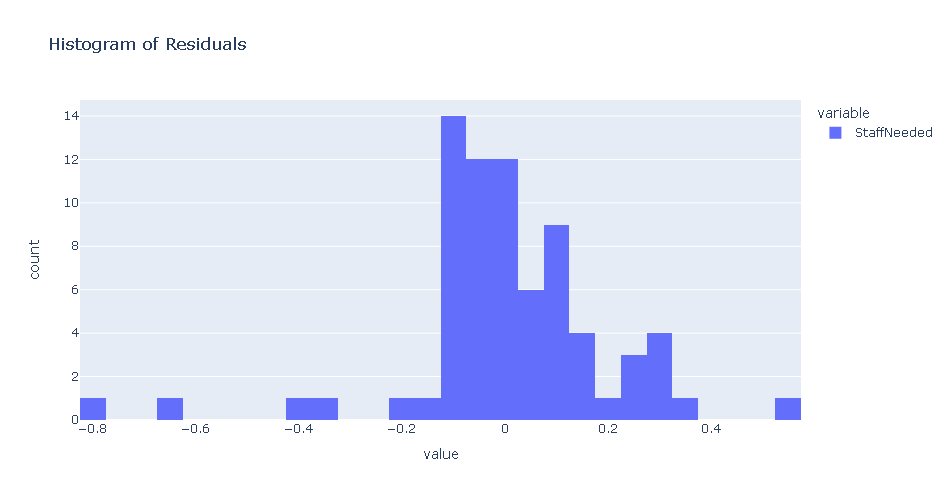

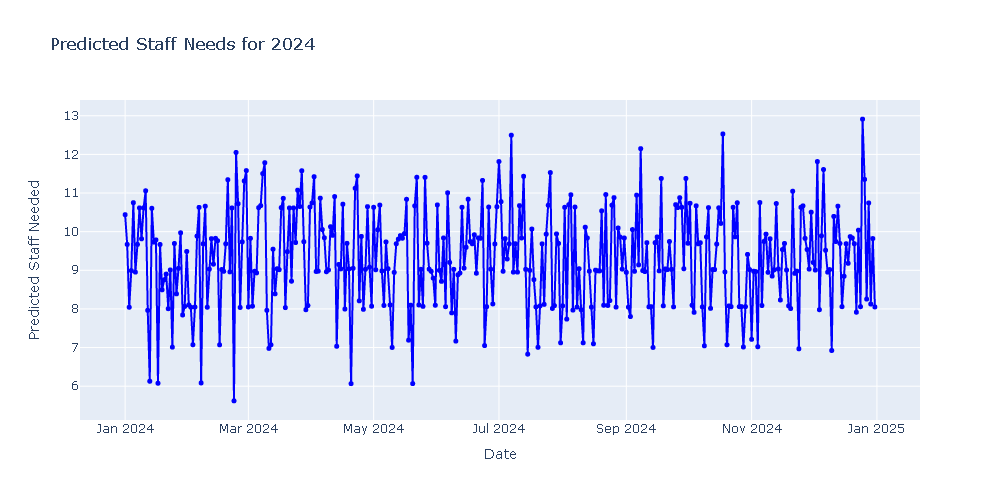

,Date,DayOfWeek,Visitors,Sales,IsHoliday,Promo,Temperature,WeatherType,Month,WeekOfYear,VisitorToSalesRatio,PredictedStaffNeeded
2024-01-01,2024-01-01,0,0.634146,0.295520,True,1,18.385529,Rainy,1,1,2.145865,10.438631
2024-01-02,2024-01-02,1,0.634146,0.353224,False,0,5.620744,Rainy,1,1,1.795308,9.670009
2024-01-03,2024-01-03,2,0.426829,0.431632,False,0,17.166250,Snowy,1,1,0.988874,8.043488
2024-01-04,2024-01-04,3,0.707317,0.235722,False,0,4.742473,Sunny,1,1,3.000640,8.990584
2024-01-05,2024-01-05,4,0.621951,0.504715,False,1,26.008214,Rainy,1,1,1.232281,10.749509
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,2024-12-27,4,0.585366,0.248987,False,0,7.719229,Sunny,12,52,2.350986,8.254189
2024-12-28,2024-12-28,5,0.780488,0.593753,False,0,18.733486,Sunny,12,52,1.314499,10.742211
2024-12-29,2024-12-29,6,0.597561,0.208895,False,0,18.123782,Sunny,12,52,2.860580,8.126073
2024-12-30,2024-12-30,0,0.524390,0.706684,False,0,26.927352,Rainy,12,1,0.742043,9.821453


In [3]:
np.random.seed(42)
num_days = 365
dates = pd.date_range(start="2023-01-01", periods=num_days, freq='D')
data = pd.DataFrame({
    'Date': dates,
    'DayOfWeek': dates.dayofweek,
    'Visitors': np.random.poisson(lam=200, size=num_days),
    'Sales': np.random.normal(loc=1000, scale=300, size=num_days),
    'IsHoliday': (dates.isin([pd.Timestamp('2023-01-01'), pd.Timestamp('2023-07-04'), pd.Timestamp('2023-12-25')])),
    'Promo': np.random.binomial(1, 0.2, num_days)
})

# Добавляем погодные условия
data['Temperature'] = np.random.normal(loc=15, scale=10, size=num_days)  # Средняя температура
data['WeatherType'] = np.random.choice(['Sunny', 'Rainy', 'Snowy'], size=num_days, p=[0.7, 0.2, 0.1])

# Добавляем временные признаки
data['Month'] = data['Date'].dt.month
data['WeekOfYear'] = data['Date'].dt.isocalendar().week

# Признаковая инженерия
data['VisitorToSalesRatio'] = data['Visitors'] / data['Sales']

# Нормализация продаж и посетителей

scaler = MinMaxScaler()
data[['Visitors', 'Sales']] = scaler.fit_transform(data[['Visitors', 'Sales']])

# Рассчитываем потребность в персонале
data['StaffNeeded'] = (5 + (data['Visitors'] * 100 // 15) + (data['Sales'] * 100 // 30) + data['IsHoliday'] * 2 + data['Promo']).astype(int)

numeric_data = data.select_dtypes(include=[np.number])

# Вычисление корреляционной матрицы только для числовых данных
correlation_matrix = numeric_data.corr()

# Создание тепловой карты
plt.figure(figsize=(9, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Тепловая карта корреляций числовых признаков')
plt.show()

X = data.drop(['Date', 'StaffNeeded'], axis=1)
y = data['StaffNeeded']

# Разделение категориальных и числовых признаков
categorical_features = ['DayOfWeek', 'IsHoliday', 'Promo', 'WeatherType', 'Month']
numeric_features = ['Visitors', 'Sales', 'Temperature', 'VisitorToSalesRatio', 'WeekOfYear']

# Создание трансформера с предварительной обработкой
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))])

cv_scores = cross_val_score(gb_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
print("Средний MSE из кросс-валидации:", -np.mean(cv_scores))

# Обучение моделей
gb_pipeline.fit(X_train, y_train)

# Предсказание на тестовых данных
gb_pred = gb_pipeline.predict(X_test)

# Создание графика


gb_mse = mean_squared_error(y_test, gb_pred)
gb_r2 = r2_score(y_test, gb_pred)

print("Gradient Boosting: MSE =", gb_mse, "R^2 =", gb_r2)

fig = px.scatter(x=y_test, y=gb_pred, labels={'x': 'Actual Staff Needed', 'y': 'Predicted Staff Needed'},
                 title='Comparison of Actual and Predicted Staff Needs', opacity=0.6)
# Добавление линии идеального соответствия
fig.add_shape(type='line', x0=y_test.min(), y0=y_test.min(), x1=y_test.max(), y1=y_test.max(),
              line=dict(color="Red", width=2, dash='dash'))

# Установка размера графика
fig.update_layout(
    width=1000,  # ширина в пикселях
    height=500   # высота в пикселях
)

# Показать график
fig.show("png")
# Оценка моделей

residuals = y_test - gb_pred

# Создание интерактивного графика остатков
fig = px.scatter(x=gb_pred, y=residuals, labels={'x': 'Predicted Staff Needed', 'y': 'Residuals'},
                 title='Residuals Plot')
fig.add_hline(y=0, line_dash="dash", line_color="red")

# Установка размера графика
fig.update_layout(
    width=1000,  # ширина в пикселях
    height=500   # высота в пикселях
)

fig.show("png")

# Создание гистограммы остатков
fig = px.histogram(
    residuals, 
    nbins=30, 
    title='Histogram of Residuals'
)

# Установка размера графика
fig.update_layout(
    width=950,  # ширина в пикселях
    height=500   # высота в пикселях
)

# Показать график
fig.show("png")

# Генерация данных за 2024 год
num_days_2024 = 366
dates_2024 = pd.date_range(start="2024-01-01", periods=num_days_2024, freq='D')
test_data_2024 = pd.DataFrame({
    'Date': dates_2024,
    'DayOfWeek': dates_2024.dayofweek,
    'Visitors': np.random.poisson(lam=200, size=num_days_2024),
    'Sales': np.random.normal(loc=1000, scale=300, size=num_days_2024),
    'IsHoliday': (dates_2024.isin([pd.Timestamp('2024-01-01'), pd.Timestamp('2024-07-04'), pd.Timestamp('2024-12-25')])),
    'Promo': np.random.binomial(1, 0.2, num_days_2024),
    'Temperature': np.random.normal(loc=15, scale=10, size=num_days_2024),
    'WeatherType': np.random.choice(['Sunny', 'Rainy', 'Snowy'], size=num_days_2024, p=[0.7, 0.2, 0.1]),
    'Month': dates_2024.month,
    'WeekOfYear': dates_2024.isocalendar().week
})

# Нормализация и масштабирование данных
test_data_2024[['Visitors', 'Sales']] = scaler.transform(test_data_2024[['Visitors', 'Sales']])
test_data_2024['VisitorToSalesRatio'] = test_data_2024['Visitors'] / test_data_2024['Sales']

# Удаление столбца 'Date'
X_test_2024 = test_data_2024.drop(['Date'], axis=1)


predictions_2024 = gb_pipeline.predict(X_test_2024)

# Визуализация прогнозов
fig = px.line(
    x=dates_2024, 
    y=predictions_2024, 
    labels={'x': 'Date', 'y': 'Predicted Staff Needed'},
    title='Predicted Staff Needs for 2024'
)

# Добавление маркировки данных на график
fig.update_traces(mode='lines+markers', marker=dict(size=5, color='blue'), line=dict(color='blue'))

# Установка размера графика
fig.update_layout(
    width=1000,  # ширина в пикселях
    height=500   # высота в пикселях
)

# Показать график
fig.show("png")

test_data_2024['PredictedStaffNeeded'] = predictions_2024

test_data_2024
